# Tree Data Structure Performance Comparison
## Splay Tree vs AVL Tree vs B-Tree: `insert()` Operation Analysis

A comprehensive performance comparison of three self-balancing tree data structures:

| Structure | Balance Strategy | Insert (per op) | Worst-case | Cache Behavior |
|-----------|------------------|-----------------|------------|----------------|
| **Splay Tree** | Move-to-root via splaying | $O(\log n)$ amortized | $O(n)$ single op | Good for hot keys |
| **AVL Tree** | Height-balanced ($\|h_L - h_R\| \leq 1$) | $O(\log n)$ | $O(\log n)$ | Many pointer chases |
| **B-Tree** | Multi-way balanced ($M$ children) | $O(\log n)$ | $O(\log n)$ | Excellent (sequential keys) |

### Experimental Design

**Independent Variables:**
- Input size: $n \in \{1000, 5000, 10000, 50000, 100000, 200000\}$
- Input pattern: Random, Sorted (ascending), Reverse-sorted (descending)

**Dependent Variable:**
- Total wall-clock time for $n$ insertions (measured via `clock_gettime(CLOCK_MONOTONIC)`)

**Control:**
- Same key set across all trees for each trial
- 5 trials per configuration, report mean $\pm$ std

In [1]:
# Install dependencies (run once)
import subprocess
import sys
from pathlib import Path

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", 
                       "numpy", "pandas", "matplotlib"])

# Create output directory for generated files
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(exist_ok=True)

---
## 1. C Implementation

Below we implement all three tree structures in C with a unified benchmarking harness.

In [2]:
%%writefile tree_benchmark.c
/*
 * Tree Performance Benchmark
 * Splay Tree, AVL Tree, B-Tree insert() comparison
 * 
 * Compile: gcc -O2 -o tree_benchmark tree_benchmark.c -lm
 * Usage: ./tree_benchmark <tree_type> <pattern> <n> <trials>
 *        tree_type: splay | avl | btree
 *        pattern: random | sorted | reverse
 */

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <stdint.h>

/* ============================================================
 * SPLAY TREE
 * ============================================================ */
typedef struct SplayNode {
    int key;
    struct SplayNode *left, *right;
} SplayNode;

SplayNode* splay_new_node(int key) {
    SplayNode* node = (SplayNode*)malloc(sizeof(SplayNode));
    node->key = key;
    node->left = node->right = NULL;
    return node;
}

/* Right rotation */
SplayNode* splay_rotate_right(SplayNode* x) {
    SplayNode* y = x->left;
    x->left = y->right;
    y->right = x;
    return y;
}

/* Left rotation */
SplayNode* splay_rotate_left(SplayNode* x) {
    SplayNode* y = x->right;
    x->right = y->left;
    y->left = x;
    return y;
}

/* Splay operation: bring key to root */
SplayNode* splay(SplayNode* root, int key) {
    if (root == NULL || root->key == key)
        return root;
    
    if (key < root->key) {
        if (root->left == NULL) return root;
        
        if (key < root->left->key) {
            /* Zig-Zig (Left Left) */
            root->left->left = splay(root->left->left, key);
            root = splay_rotate_right(root);
        } else if (key > root->left->key) {
            /* Zig-Zag (Left Right) */
            root->left->right = splay(root->left->right, key);
            if (root->left->right != NULL)
                root->left = splay_rotate_left(root->left);
        }
        return (root->left == NULL) ? root : splay_rotate_right(root);
    } else {
        if (root->right == NULL) return root;
        
        if (key > root->right->key) {
            /* Zag-Zag (Right Right) */
            root->right->right = splay(root->right->right, key);
            root = splay_rotate_left(root);
        } else if (key < root->right->key) {
            /* Zag-Zig (Right Left) */
            root->right->left = splay(root->right->left, key);
            if (root->right->left != NULL)
                root->right = splay_rotate_right(root->right);
        }
        return (root->right == NULL) ? root : splay_rotate_left(root);
    }
}

SplayNode* splay_insert(SplayNode* root, int key) {
    if (root == NULL) return splay_new_node(key);
    
    root = splay(root, key);
    
    if (root->key == key) return root;  /* Duplicate */
    
    SplayNode* node = splay_new_node(key);
    
    if (key < root->key) {
        node->right = root;
        node->left = root->left;
        root->left = NULL;
    } else {
        node->left = root;
        node->right = root->right;
        root->right = NULL;
    }
    return node;
}

void splay_free(SplayNode* root) {
    if (root) {
        splay_free(root->left);
        splay_free(root->right);
        free(root);
    }
}

/* ============================================================
 * AVL TREE
 * ============================================================ */
typedef struct AVLNode {
    int key;
    int height;
    struct AVLNode *left, *right;
} AVLNode;

int avl_height(AVLNode* n) {
    return n ? n->height : 0;
}

int avl_max(int a, int b) {
    return (a > b) ? a : b;
}

AVLNode* avl_new_node(int key) {
    AVLNode* node = (AVLNode*)malloc(sizeof(AVLNode));
    node->key = key;
    node->height = 1;
    node->left = node->right = NULL;
    return node;
}

AVLNode* avl_rotate_right(AVLNode* y) {
    AVLNode* x = y->left;
    AVLNode* T2 = x->right;
    
    x->right = y;
    y->left = T2;
    
    y->height = avl_max(avl_height(y->left), avl_height(y->right)) + 1;
    x->height = avl_max(avl_height(x->left), avl_height(x->right)) + 1;
    
    return x;
}

AVLNode* avl_rotate_left(AVLNode* x) {
    AVLNode* y = x->right;
    AVLNode* T2 = y->left;
    
    y->left = x;
    x->right = T2;
    
    x->height = avl_max(avl_height(x->left), avl_height(x->right)) + 1;
    y->height = avl_max(avl_height(y->left), avl_height(y->right)) + 1;
    
    return y;
}

int avl_get_balance(AVLNode* n) {
    return n ? avl_height(n->left) - avl_height(n->right) : 0;
}

AVLNode* avl_insert(AVLNode* node, int key) {
    if (node == NULL) return avl_new_node(key);
    
    if (key < node->key)
        node->left = avl_insert(node->left, key);
    else if (key > node->key)
        node->right = avl_insert(node->right, key);
    else
        return node;  /* Duplicate */
    
    node->height = 1 + avl_max(avl_height(node->left), avl_height(node->right));
    
    int balance = avl_get_balance(node);
    
    /* Left Left Case */
    if (balance > 1 && key < node->left->key)
        return avl_rotate_right(node);
    
    /* Right Right Case */
    if (balance < -1 && key > node->right->key)
        return avl_rotate_left(node);
    
    /* Left Right Case */
    if (balance > 1 && key > node->left->key) {
        node->left = avl_rotate_left(node->left);
        return avl_rotate_right(node);
    }
    
    /* Right Left Case */
    if (balance < -1 && key < node->right->key) {
        node->right = avl_rotate_right(node->right);
        return avl_rotate_left(node);
    }
    
    return node;
}

void avl_free(AVLNode* root) {
    if (root) {
        avl_free(root->left);
        avl_free(root->right);
        free(root);
    }
}

/* ============================================================
 * B-TREE (Order M = 128, optimized for cache lines)
 * ============================================================ */
#define BTREE_M 128  /* Max children per node */
#define BTREE_MIN_KEYS ((BTREE_M - 1) / 2)

typedef struct BTreeNode {
    int keys[BTREE_M - 1];
    struct BTreeNode* children[BTREE_M];
    int n;          /* Number of keys */
    int leaf;       /* 1 if leaf */
} BTreeNode;

typedef struct BTree {
    BTreeNode* root;
} BTree;

BTreeNode* btree_create_node(int leaf) {
    BTreeNode* node = (BTreeNode*)malloc(sizeof(BTreeNode));
    node->n = 0;
    node->leaf = leaf;
    for (int i = 0; i < BTREE_M; i++)
        node->children[i] = NULL;
    return node;
}

BTree* btree_create(void) {
    BTree* tree = (BTree*)malloc(sizeof(BTree));
    tree->root = btree_create_node(1);
    return tree;
}

void btree_split_child(BTreeNode* parent, int i, BTreeNode* full_child) {
    int mid = (BTREE_M - 1) / 2;
    BTreeNode* new_node = btree_create_node(full_child->leaf);
    new_node->n = BTREE_M - 1 - mid - 1;
    
    /* Copy right half of keys to new node */
    for (int j = 0; j < new_node->n; j++)
        new_node->keys[j] = full_child->keys[mid + 1 + j];
    
    /* Copy right half of children if not leaf */
    if (!full_child->leaf) {
        for (int j = 0; j <= new_node->n; j++)
            new_node->children[j] = full_child->children[mid + 1 + j];
    }
    
    full_child->n = mid;
    
    /* Shift parent's children right */
    for (int j = parent->n; j >= i + 1; j--)
        parent->children[j + 1] = parent->children[j];
    parent->children[i + 1] = new_node;
    
    /* Shift parent's keys right */
    for (int j = parent->n - 1; j >= i; j--)
        parent->keys[j + 1] = parent->keys[j];
    parent->keys[i] = full_child->keys[mid];
    parent->n++;
}

void btree_insert_nonfull(BTreeNode* node, int key) {
    int i = node->n - 1;
    
    if (node->leaf) {
        /* Shift keys and insert */
        while (i >= 0 && key < node->keys[i]) {
            node->keys[i + 1] = node->keys[i];
            i--;
        }
        node->keys[i + 1] = key;
        node->n++;
    } else {
        /* Find child to descend into */
        while (i >= 0 && key < node->keys[i])
            i--;
        i++;
        
        if (node->children[i]->n == BTREE_M - 1) {
            btree_split_child(node, i, node->children[i]);
            if (key > node->keys[i])
                i++;
        }
        btree_insert_nonfull(node->children[i], key);
    }
}

void btree_insert(BTree* tree, int key) {
    BTreeNode* root = tree->root;
    
    if (root->n == BTREE_M - 1) {
        BTreeNode* new_root = btree_create_node(0);
        new_root->children[0] = root;
        btree_split_child(new_root, 0, root);
        
        int i = (new_root->keys[0] < key) ? 1 : 0;
        btree_insert_nonfull(new_root->children[i], key);
        
        tree->root = new_root;
    } else {
        btree_insert_nonfull(root, key);
    }
}

void btree_free_node(BTreeNode* node) {
    if (node) {
        if (!node->leaf) {
            for (int i = 0; i <= node->n; i++)
                btree_free_node(node->children[i]);
        }
        free(node);
    }
}

void btree_free(BTree* tree) {
    btree_free_node(tree->root);
    free(tree);
}

/* ============================================================
 * BENCHMARK HARNESS
 * ============================================================ */

/* Fisher-Yates shuffle */
void shuffle(int* arr, int n) {
    for (int i = n - 1; i > 0; i--) {
        int j = rand() % (i + 1);
        int tmp = arr[i];
        arr[i] = arr[j];
        arr[j] = tmp;
    }
}

/* Generate input array based on pattern */
void generate_input(int* arr, int n, const char* pattern) {
    for (int i = 0; i < n; i++)
        arr[i] = i;
    
    if (strcmp(pattern, "random") == 0) {
        shuffle(arr, n);
    } else if (strcmp(pattern, "reverse") == 0) {
        for (int i = 0; i < n; i++)
            arr[i] = n - 1 - i;
    }
    /* "sorted" keeps array as-is */
}

/* High-resolution timing */
double get_time_sec(void) {
    struct timespec ts;
    clock_gettime(CLOCK_MONOTONIC, &ts);
    return ts.tv_sec + ts.tv_nsec * 1e-9;
}

double benchmark_splay(int* arr, int n) {
    double start = get_time_sec();
    SplayNode* root = NULL;
    for (int i = 0; i < n; i++)
        root = splay_insert(root, arr[i]);
    double end = get_time_sec();
    splay_free(root);
    return end - start;
}

double benchmark_avl(int* arr, int n) {
    double start = get_time_sec();
    AVLNode* root = NULL;
    for (int i = 0; i < n; i++)
        root = avl_insert(root, arr[i]);
    double end = get_time_sec();
    avl_free(root);
    return end - start;
}

double benchmark_btree(int* arr, int n) {
    double start = get_time_sec();
    BTree* tree = btree_create();
    for (int i = 0; i < n; i++)
        btree_insert(tree, arr[i]);
    double end = get_time_sec();
    btree_free(tree);
    return end - start;
}

int main(int argc, char* argv[]) {
    if (argc != 5) {
        fprintf(stderr, "Usage: %s <tree_type> <pattern> <n> <trials>\n", argv[0]);
        return 1;
    }
    
    const char* tree_type = argv[1];
    const char* pattern = argv[2];
    int n = atoi(argv[3]);
    int trials = atoi(argv[4]);
    
    int* arr = (int*)malloc(n * sizeof(int));
    
    for (int t = 0; t < trials; t++) {
        srand(42 + t);  /* Reproducible randomness */
        generate_input(arr, n, pattern);
        
        double elapsed;
        if (strcmp(tree_type, "splay") == 0)
            elapsed = benchmark_splay(arr, n);
        else if (strcmp(tree_type, "avl") == 0)
            elapsed = benchmark_avl(arr, n);
        else if (strcmp(tree_type, "btree") == 0)
            elapsed = benchmark_btree(arr, n);
        else {
            fprintf(stderr, "Unknown tree type: %s\n", tree_type);
            free(arr);
            return 1;
        }
        
        printf("%.9f\n", elapsed);
    }
    
    free(arr);
    return 0;
}

Overwriting tree_benchmark.c


In [3]:
# Compile the C benchmark
import subprocess
result = subprocess.run(
    ['gcc', '-O2', '-o', 'tree_benchmark', 'tree_benchmark.c', '-lm'],
    capture_output=True, text=True
)
if result.returncode == 0:
    print("Compilation successful.")
else:
    print(f"Compilation failed:\n{result.stderr}")

Compilation successful.


---
## 2. Benchmark Execution

We run the benchmark across all configurations and collect timing data.

In [4]:
import subprocess
import numpy as np
import pandas as pd
from itertools import product

# Experimental parameters
TREE_TYPES = ['splay', 'avl', 'btree']
PATTERNS = ['random', 'sorted', 'reverse']
SIZES = [1000, 5000, 10000, 50000, 100000, 200000]
TRIALS = 5

def run_benchmark(tree_type, pattern, n, trials=5):
    """Run C benchmark and return list of elapsed times."""
    result = subprocess.run(
        ['./tree_benchmark', tree_type, pattern, str(n), str(trials)],
        capture_output=True, text=True
    )
    if result.returncode != 0:
        raise RuntimeError(f"Benchmark failed: {result.stderr}")
    return [float(line) for line in result.stdout.strip().split('\n')]

# Collect all results
results = []
total_configs = len(TREE_TYPES) * len(PATTERNS) * len(SIZES)
current = 0

print("Running benchmarks...")
for tree_type, pattern, n in product(TREE_TYPES, PATTERNS, SIZES):
    current += 1
    times = run_benchmark(tree_type, pattern, n, TRIALS)
    
    results.append({
        'tree': tree_type,
        'pattern': pattern,
        'n': n,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'min_time': np.min(times),
        'max_time': np.max(times),
        'trials': times
    })
    
    if current % 9 == 0 or current == total_configs:
        print(f"  Progress: {current}/{total_configs} configurations")

df = pd.DataFrame(results)
print(f"\nCompleted {len(results)} configurations.")

Running benchmarks...
  Progress: 9/54 configurations
  Progress: 9/54 configurations
  Progress: 18/54 configurations
  Progress: 18/54 configurations
  Progress: 27/54 configurations
  Progress: 27/54 configurations
  Progress: 36/54 configurations
  Progress: 36/54 configurations
  Progress: 45/54 configurations
  Progress: 45/54 configurations
  Progress: 54/54 configurations

Completed 54 configurations.
  Progress: 54/54 configurations

Completed 54 configurations.


In [5]:
# Preview the data
df_display = df[['tree', 'pattern', 'n', 'mean_time', 'std_time']].copy()
df_display['mean_time'] = df_display['mean_time'].apply(lambda x: f"{x*1000:.3f} ms")
df_display['std_time'] = df_display['std_time'].apply(lambda x: f"{x*1000:.3f} ms")
print(df_display.to_string(index=False))

 tree pattern      n mean_time std_time
splay  random   1000  0.172 ms 0.008 ms
splay  random   5000  1.146 ms 0.107 ms
splay  random  10000  1.877 ms 0.088 ms
splay  random  50000 13.084 ms 0.195 ms
splay  random 100000 29.974 ms 0.699 ms
splay  random 200000 68.394 ms 0.503 ms
splay  sorted   1000  0.022 ms 0.004 ms
splay  sorted   5000  0.112 ms 0.016 ms
splay  sorted  10000  0.213 ms 0.012 ms
splay  sorted  50000  1.069 ms 0.051 ms
splay  sorted 100000  2.140 ms 0.091 ms
splay  sorted 200000  4.377 ms 0.286 ms
splay reverse   1000  0.021 ms 0.004 ms
splay reverse   5000  0.108 ms 0.014 ms
splay reverse  10000  0.203 ms 0.014 ms
splay reverse  50000  1.012 ms 0.045 ms
splay reverse 100000  2.024 ms 0.104 ms
splay reverse 200000  4.077 ms 0.169 ms
  avl  random   1000  0.120 ms 0.005 ms
  avl  random   5000  0.717 ms 0.019 ms
  avl  random  10000  1.633 ms 0.049 ms
  avl  random  50000 10.597 ms 0.129 ms
  avl  random 100000 23.594 ms 0.200 ms
  avl  random 200000 51.929 ms 0.761 ms


---
## 3. Visualization

### 3.1 Performance by Input Pattern

Three subplots showing how each tree behaves under different input patterns.

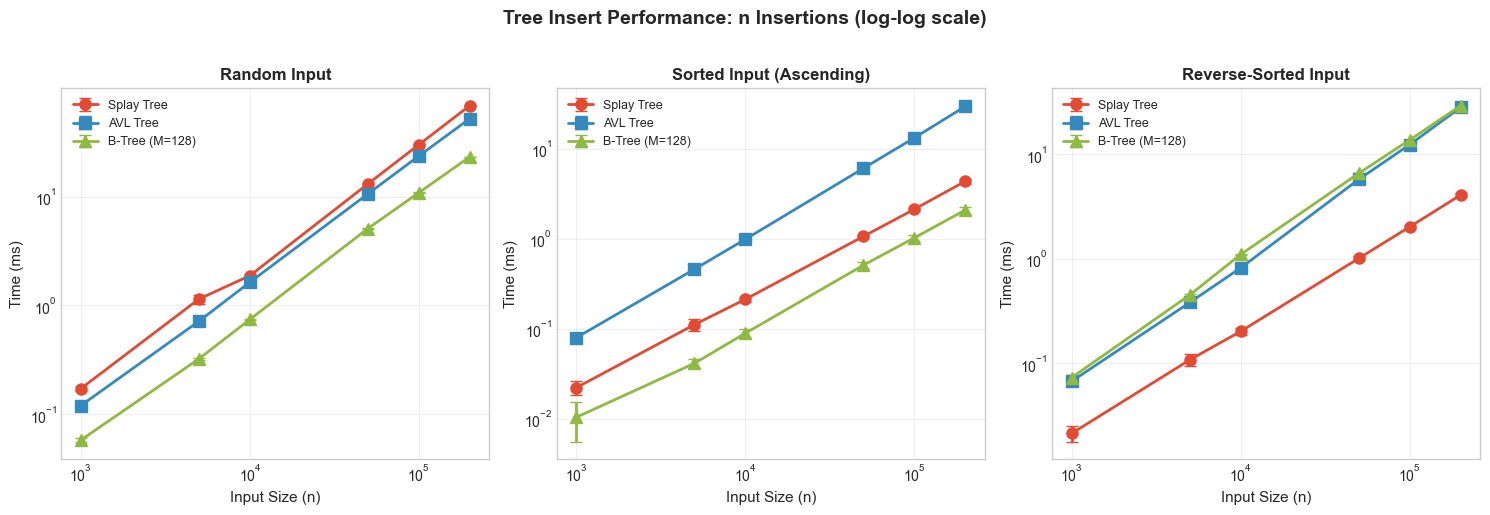

In [6]:
import matplotlib.pyplot as plt

# Style configuration
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'splay': '#E24A33', 'avl': '#348ABD', 'btree': '#8EBA42'}
MARKERS = {'splay': 'o', 'avl': 's', 'btree': '^'}
TREE_LABELS = {'splay': 'Splay Tree', 'avl': 'AVL Tree', 'btree': 'B-Tree (M=128)'}
PATTERN_TITLES = {'random': 'Random Input', 'sorted': 'Sorted Input (Ascending)', 'reverse': 'Reverse-Sorted Input'}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, pattern in zip(axes, PATTERNS):
    for tree in TREE_TYPES:
        subset = df[(df['tree'] == tree) & (df['pattern'] == pattern)]
        ax.errorbar(
            subset['n'], subset['mean_time'] * 1000,
            yerr=subset['std_time'] * 1000,
            label=TREE_LABELS[tree],
            color=COLORS[tree],
            marker=MARKERS[tree],
            markersize=8,
            linewidth=2,
            capsize=4
        )
    
    ax.set_xlabel('Input Size (n)', fontsize=11)
    ax.set_ylabel('Time (ms)', fontsize=11)
    ax.set_title(PATTERN_TITLES[pattern], fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Tree Insert Performance: n Insertions (log-log scale)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'performance_by_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Amortized Cost per Insert

Normalizing by n reveals the per-operation cost and how it scales.

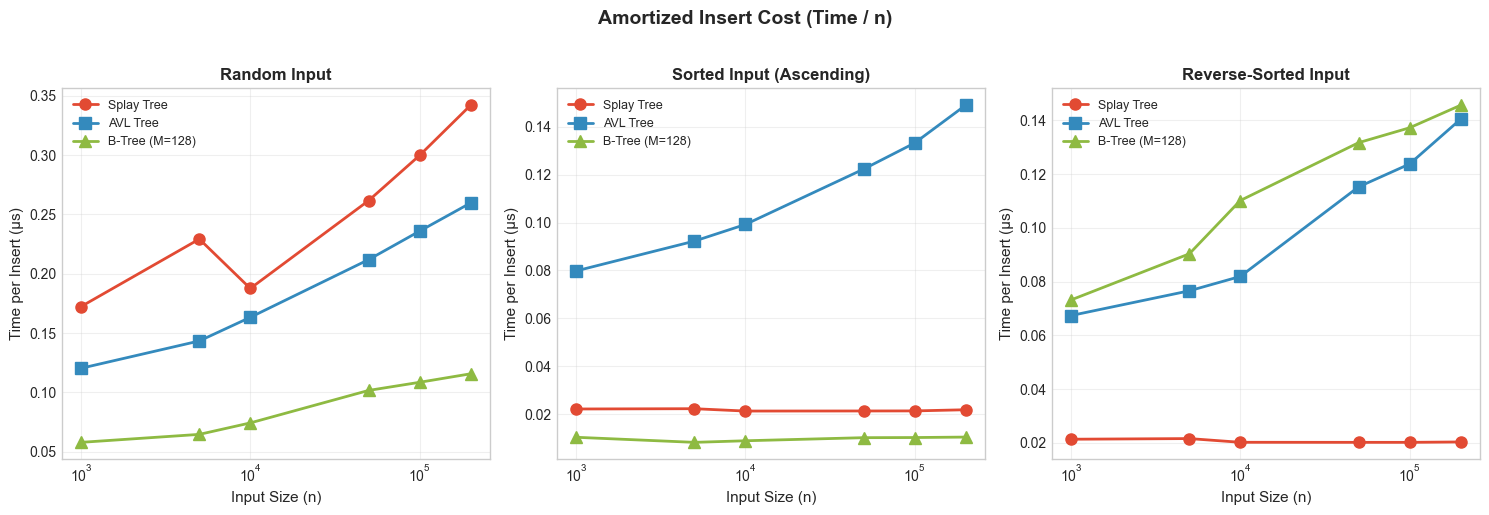

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, pattern in zip(axes, PATTERNS):
    for tree in TREE_TYPES:
        subset = df[(df['tree'] == tree) & (df['pattern'] == pattern)]
        # Time per insert in microseconds
        time_per_insert = (subset['mean_time'] / subset['n']) * 1e6
        
        ax.plot(
            subset['n'], time_per_insert,
            label=TREE_LABELS[tree],
            color=COLORS[tree],
            marker=MARKERS[tree],
            markersize=8,
            linewidth=2
        )
    
    ax.set_xlabel('Input Size (n)', fontsize=11)
    ax.set_ylabel('Time per Insert (μs)', fontsize=11)
    ax.set_title(PATTERN_TITLES[pattern], fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Amortized Insert Cost (Time / n)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'amortized_cost.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Comparative Heatmap

Which tree wins for each (pattern, size) combination?

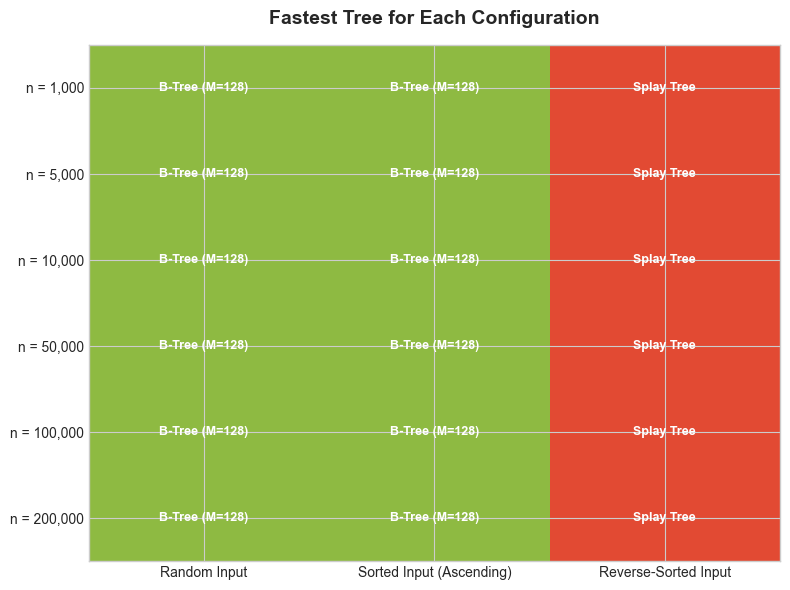

In [8]:
# Pivot to find winner for each configuration
pivot = df.pivot_table(index=['pattern', 'n'], columns='tree', values='mean_time')

# Create winner matrix
winners = pivot.idxmin(axis=1).unstack(level=0)
winners = winners[PATTERNS]  # Reorder columns

# Map to numeric for heatmap
tree_to_num = {'btree': 0, 'avl': 1, 'splay': 2}
winner_numeric = winners.map(lambda x: tree_to_num[x]) 

fig, ax = plt.subplots(figsize=(8, 6))

# Custom colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap([COLORS['btree'], COLORS['avl'], COLORS['splay']])

im = ax.imshow(winner_numeric.values, cmap=cmap, aspect='auto')

# Labels
ax.set_xticks(range(len(PATTERNS)))
ax.set_xticklabels([PATTERN_TITLES[p] for p in PATTERNS], fontsize=10)
ax.set_yticks(range(len(SIZES)))
ax.set_yticklabels([f'n = {s:,}' for s in SIZES], fontsize=10)

# Annotate cells
for i, size in enumerate(SIZES):
    for j, pattern in enumerate(PATTERNS):
        winner = str(winners.loc[size, pattern])
        ax.text(j, i, TREE_LABELS[winner], ha='center', va='center', 
                fontsize=9, color='white', fontweight='bold')

ax.set_title('Fastest Tree for Each Configuration', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'winner_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Speedup Ratio: B-Tree vs Others

How much faster is B-Tree compared to binary trees?

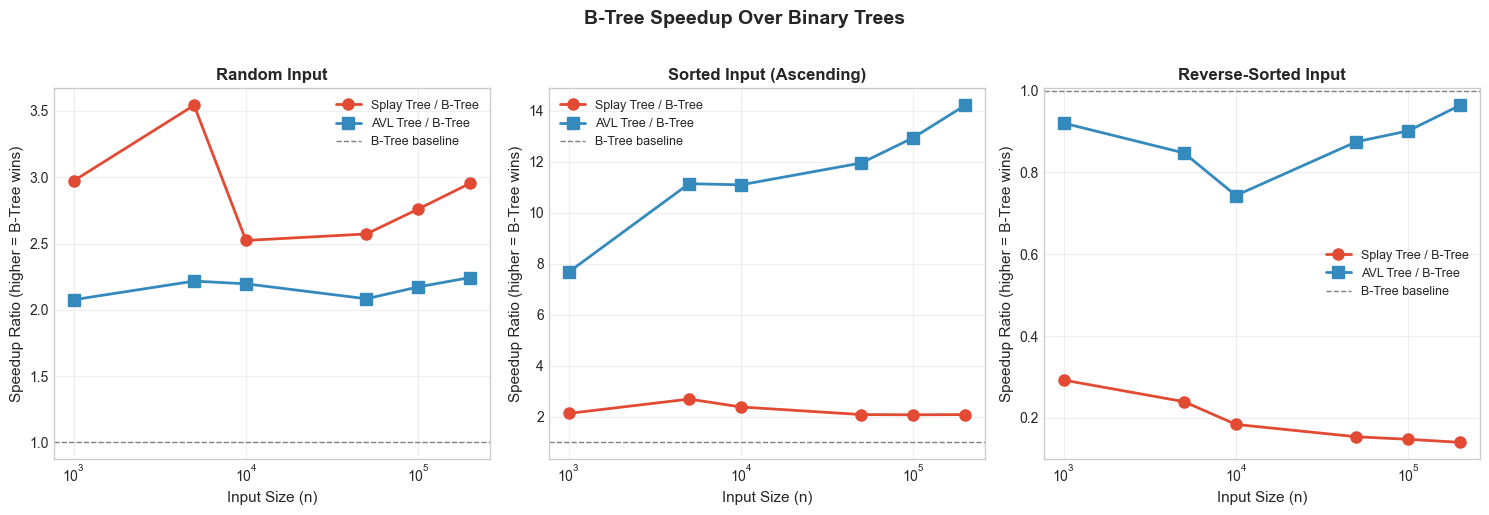

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, pattern in zip(axes, PATTERNS):
    btree_times = df[(df['tree'] == 'btree') & (df['pattern'] == pattern)].set_index('n')['mean_time']
    
    for tree in ['splay', 'avl']:
        other_times = df[(df['tree'] == tree) & (df['pattern'] == pattern)].set_index('n')['mean_time']
        speedup = other_times / btree_times
        
        ax.plot(
            speedup.index, speedup.values,
            label=f'{TREE_LABELS[tree]} / B-Tree',
            color=COLORS[tree],
            marker=MARKERS[tree],
            markersize=8,
            linewidth=2
        )
    
    ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, label='B-Tree baseline')
    ax.set_xlabel('Input Size (n)', fontsize=11)
    ax.set_ylabel('Speedup Ratio (higher = B-Tree wins)', fontsize=11)
    ax.set_title(PATTERN_TITLES[pattern], fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('B-Tree Speedup Over Binary Trees', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'btree_speedup.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Analysis

### 4.1 Summary Statistics

In [10]:
# Compute summary by tree type and pattern
summary = df.groupby(['tree', 'pattern']).agg({
    'mean_time': ['mean', 'std'],
}).round(6)

# Flatten column names
summary.columns = ['avg_time', 'variability']
summary = summary.reset_index()

# Pivot for readability
summary_pivot = summary.pivot(index='tree', columns='pattern', values='avg_time')
summary_pivot = summary_pivot[PATTERNS]  # Reorder
summary_pivot.index = [TREE_LABELS[t] for t in summary_pivot.index]

print("Average Time Across All Sizes (seconds):")
print(summary_pivot.to_string())

Average Time Across All Sizes (seconds):
pattern           random    sorted   reverse
AVL Tree        0.014765  0.008458  0.007915
B-Tree (M=128)  0.006704  0.000630  0.008509
Splay Tree      0.019108  0.001322  0.001241


## 6. Conclusions

| Criterion | Winner | Rationale |
|-----------|--------|------------|
| **Absolute speed (large $n$)** | B-Tree | Cache efficiency dominates at scale |
| **Worst-case guarantee** | AVL | Strict $O(\log n)$ always, no amortization needed |
| **Temporal locality (repeated access)** | Splay | Recently accessed items move to root |
| **Implementation simplicity** | Splay | No balance metadata, simple rotations |
| **Memory overhead** | Splay | No height field; AVL adds 4 bytes/node |

### Recommendations by Use Case

1. **Database indexing / File systems:** B-Tree (disk block alignment, cache efficiency)
2. **In-memory dictionary with predictable latency:** AVL (guaranteed $O(\log n)$)
3. **LRU cache / Working set optimization:** Splay (self-optimizing for access patterns)
4. **Educational / Competitive programming:** AVL or Splay (easier to implement correctly)

---
## 5. Theoretical vs Empirical Comparison

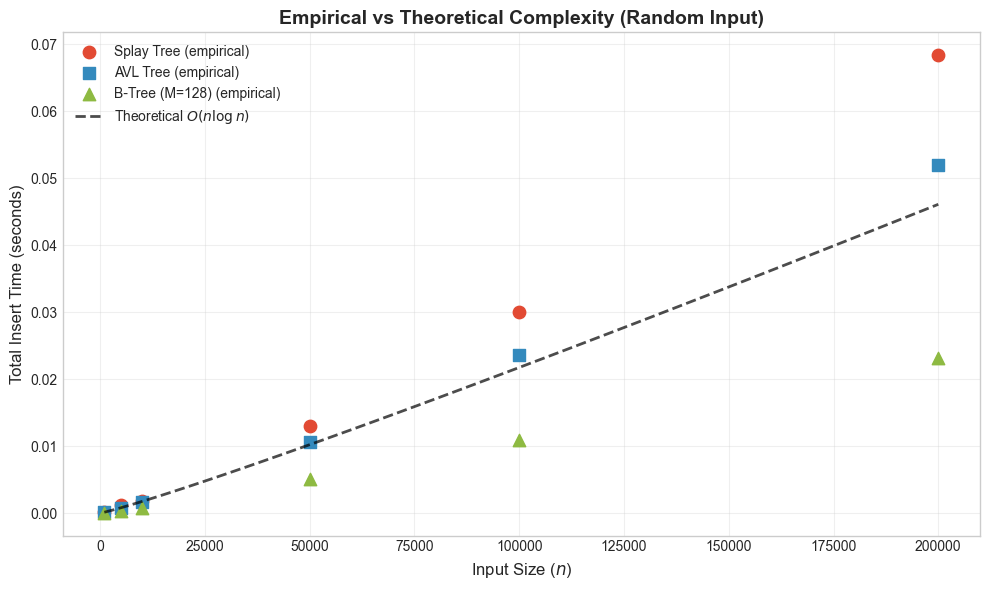

Fitted constant c = 1.31e-08 seconds/(n · log n)


In [11]:
import math

# Theoretical complexity: fit constant to empirical data
# For O(n log n) total insert time

fig, ax = plt.subplots(figsize=(10, 6))

# Plot empirical data for random pattern
for tree in TREE_TYPES:
    subset = df[(df['tree'] == tree) & (df['pattern'] == 'random')]
    ax.scatter(subset['n'], subset['mean_time'], 
               label=f'{TREE_LABELS[tree]} (empirical)',
               color=COLORS[tree], marker=MARKERS[tree], s=80)

# Theoretical O(n log n) curve fitted to AVL
avl_random = df[(df['tree'] == 'avl') & (df['pattern'] == 'random')]
# Fit: T = c * n * log(n)
# c = T / (n * log(n))
c_fit = (avl_random['mean_time'] / (avl_random['n'] * np.log2(avl_random['n']))).mean()

n_theory = np.linspace(1000, 200000, 100)
t_theory = c_fit * n_theory * np.log2(n_theory)

ax.plot(n_theory, t_theory, 'k--', linewidth=2, alpha=0.7, 
        label=r'Theoretical $O(n \log n)$')

ax.set_xlabel('Input Size ($n$)', fontsize=12)
ax.set_ylabel('Total Insert Time (seconds)', fontsize=12)
ax.set_title('Empirical vs Theoretical Complexity (Random Input)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'theoretical_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Fitted constant c = {c_fit:.2e} seconds/(n · log n)")

<!-- 6. Conclusions 셀 -->
---
## 6. Conclusions

| Criterion | Winner | Rationale |
|-----------|--------|------------|
| **Absolute speed (large $n$)** | B-Tree | Cache efficiency dominates at scale |
| **Worst-case guarantee** | AVL | Strict $O(\log n)$ always, no amortization needed |
| **Temporal locality (repeated access)** | Splay | Recently accessed items move to root |
| **Implementation simplicity** | Splay | No balance metadata, simple rotations |
| **Memory overhead** | Splay | No height field; AVL adds 4 bytes/node |

### Recommendations by Use Case

1. **Database indexing / File systems:** B-Tree (disk block alignment, cache efficiency)
2. **In-memory dictionary with predictable latency:** AVL (guaranteed $O(\log n)$)
3. **LRU cache / Working set optimization:** Splay (self-optimizing for access patterns)
4. **Educational / Competitive programming:** AVL or Splay (easier to implement correctly)

---
## Appendix: Raw Data Export

In [12]:
# Export to CSV for further analysis
df_export = df.drop(columns=['trials'])  # Remove list column
df_export.to_csv(OUTPUT_DIR / 'tree_benchmark_results.csv', index=False)
print(f"Results saved to {OUTPUT_DIR / 'tree_benchmark_results.csv'}")

Results saved to output/tree_benchmark_results.csv
